In [126]:
!pip install ultralytics torch opencv-python scikit-learn pyyaml xgboost shap

In [127]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


GPU Available: True
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [128]:
import os
import yaml
import torch
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import shutil

In [129]:
import os

def load_data(root_dir):
    """
    Load data from the specified root directory
    
    Args:
        root_dir (str): Root directory containing subject folders
    
    Returns:
        tuple: Lists of image paths and corresponding labels
    """
    data = []
    labels = []
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if os.path.isdir(subject_path):  # Check if it's a directory
            for activity_type in os.listdir(subject_path):
                activity_path = os.path.join(subject_path, activity_type)
                if os.path.isdir(activity_path):  # Check if it's a directory
                    label = 1 if activity_type == 'fall' else 0
                    for activity_class in os.listdir(activity_path):
                        class_path = os.path.join(activity_path, activity_class)
                        if os.path.isdir(class_path):  # Check if it's a directory
                            for file in os.listdir(class_path):
                                file_path = os.path.join(class_path, file)
                                if os.path.isfile(file_path):  # Ensure it's a file
                                    data.append(file_path)
                                    labels.append(label)
    return data, labels


In [130]:
import os
import shutil

def clear_output_directory(output_dir):
    """
    Deletes all files and subdirectories in the specified output directory.
    """
    if os.path.exists(output_dir):  # Check if the directory exists
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Delete files and symbolic links
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Delete directories
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")
    else:
        os.makedirs(output_dir)  # Create the directory if it does not exist

# Example Usage
output_dir = "output"  # Replace with your output directory path
clear_output_directory(output_dir)
print("Output directory cleared.")


Output directory cleared.


In [131]:
def normalize_and_save_images(input_dir, output_dir, image_size=(640, 640)):
    """
    Recursively normalize and save images while preserving directory structure.

    Args:
        input_dir (str): Root input directory containing images (possibly nested).
        output_dir (str): Output directory to save normalized images.
        image_size (tuple): Target image size (width, height) for resizing.
    """
    # Walk through the directory recursively
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                # Build input image path
                input_path = os.path.join(root, file)

                # Construct the corresponding output path
                relative_path = os.path.relpath(root, input_dir)  # Preserve sub-folder structure
                output_path_dir = os.path.join(output_dir, relative_path)
                os.makedirs(output_path_dir, exist_ok=True)  # Create subdirectories if needed
                output_path = os.path.join(output_path_dir, file)

                # Load and process the image
                image = cv2.imread(input_path)
                if image is None:
                    print(f"Warning: Unable to load {input_path}. Skipping...")
                    continue

                # Convert BGR to RGB and resize
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_resized = cv2.resize(image_rgb, image_size)

                # Normalize pixel values to [0, 1]
                image_normalized = image_resized / 255.0

                # Convert back to uint8 for saving
                image_normalized_uint8 = (image_normalized * 255).astype(np.uint8)

                # Save the normalized image
                cv2.imwrite(output_path, cv2.cvtColor(image_normalized_uint8, cv2.COLOR_RGB2BGR))

    print(f"Normalized images saved to: {output_dir}")

In [132]:
import albumentations as A
import cv2  # OpenCV is needed for image reading/writing

def augment_and_save_from_root(root_dir, output_dir, augment_ratio=2, save_original=True):
    """
    Perform data augmentation on a dataset organized by subject/activity type.

    Args:
        root_dir (str): Root directory containing subject/activity folders.
        output_dir (str): Directory to save augmented images.
        augment_ratio (int): Number of augmented images to generate per input image.
        save_original (bool): Whether to save the original image alongside augmented ones.
    """
    clear_output_directory(output_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define augmentation pipeline
    augmentation = A.Compose([
        # A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.7),
        # A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3),
        # A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), p=0.5),
        # A.GaussianBlur(blur_limit=3, p=0.2),
        # A.CLAHE(p=0.2),
        # A.ToGray(p=0.2),  # Convert some images to grayscale for variety
    ])

    augmented_data = []
    augmented_labels = []
    errors = []

    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if os.path.isdir(subject_path):
            for activity_type in os.listdir(subject_path):
                label = 1 if activity_type == 'fall' else 0
                activity_path = os.path.join(subject_path, activity_type)
                for activity_class in os.listdir(activity_path):
                    class_path = os.path.join(activity_path, activity_class)
                    for file in os.listdir(class_path):
                        img_path = os.path.join(class_path, file)
                        image = cv2.imread(img_path)
                        if image is None:
                            errors.append(img_path)
                            continue

                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                        # Create output directory structure
                        output_class_dir = os.path.join(output_dir, subject, activity_type, activity_class)
                        os.makedirs(output_class_dir, exist_ok=True)

                        # Save original image if required
                        if save_original:
                            save_path = os.path.join(output_class_dir, f"{file.split('.')[0]}_original.jpg")
                            cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
                            augmented_data.append(save_path)
                            augmented_labels.append(label)

                        # Generate augmented images
                        for i in range(augment_ratio):
                            augmented = augmentation(image=image)
                            augmented_image = augmented["image"]

                            # Save augmented image
                            aug_save_path = os.path.join(output_class_dir, f"{file.split('.')[0]}_aug{i}.jpg")
                            cv2.imwrite(aug_save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                            augmented_data.append(aug_save_path)
                            augmented_labels.append(label)

    # Log errors if any
    if errors:
        print("\n--- Errors During Augmentation ---")
        for err in errors:
            print(f"Could not process image: {err}")

    print(f"\nSaved {len(augmented_data)} images to {output_dir}")
    return augmented_data, augmented_labels
import albumentations as A
import cv2  # OpenCV is needed for image reading/writing

In [133]:
import cv2
import numpy as np
# Function to apply histogram equalization
def apply_histogram_equalization(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    equalized = cv2.equalizeHist(gray)  # Apply histogram equalization
    
    # Save the processed image back to the original path (overwriting the original file)
    cv2.imwrite(image_path, equalized)  # Replace the original file with the equalized version
    
    return image_path



In [134]:
root_dir = 'train - constrast'  # Path to the train directory

In [135]:
# for root, dirs, files in os.walk(root_dir):
#     for filename in files:
#         image_path = os.path.join(root, filename)
        
#         # Check if the file is an image
#         if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
#             equalized_image_path = apply_histogram_equalization(image_path)
#             print(f"Equalized image saved at: {equalized_image_path}")

# print("All images in the 'train' directory and subdirectories have been equalized and replaced.")

In [136]:
# Assuming the load_data function takes a directory path and loads all the images
train_data, train_labels = load_data(root_dir)

# train_data, train_labels = augment_and_save_from_root(root_dir,output_dir, augment_ratio=1)
print(f"Total images loaded: {len(train_data)}")

Total images loaded: 4342


In [137]:
import csv
import os
import shutil
from ultralytics import YOLO
import tensorflow as tf

# Create a directory for YOLO predictions
yolo_input_dir = "yolo_input"
os.makedirs(yolo_input_dir, exist_ok=True)
clear_output_directory(yolo_input_dir)

# Copy images into YOLO input directory with unique filenames and validation
for img_path in train_data:
    if os.path.exists(img_path) and os.path.isfile(img_path):
        # Create a unique filename to prevent overwriting
        unique_filename = "_".join(img_path.split(os.sep)[-3:])  # Use parent folders + filename
        unique_filepath = os.path.join(yolo_input_dir, unique_filename)
        shutil.copy(img_path, unique_filepath)
    else:
        print(f"File not found or inaccessible: {img_path}")

# Verify the total number of files copied
copied_files = os.listdir(yolo_input_dir)
print(f"Total files copied to YOLO input directory: {len(copied_files)}")

 # Initialize YOLOv8n-pose model
model = YOLO('yolov8n-pose.pt')
    
# Run predictions on the copied images
results = model.predict(
    source=yolo_input_dir,  # Directory containing images
    task="pose",
    imgsz=640,
    batch=32,
    verbose=False,
    save=False  # Save predictions
)
    
    # Output directory for saved results
print(f"Predictions saved in: {results[0].save_dir}")

Total files copied to YOLO input directory: 4342
Predictions saved in: None


In [138]:
import csv
import os
import numpy as np

# Define the output CSV path
output_csv = "yolo_keypoints.csv"

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write the CSV header
    # Header: image_name, keypoint_1_x, keypoint_1_y, ..., keypoint_17_x, keypoint_17_y
    header = ['image_name']
    for i in range(1, 18):  # Assuming 17 keypoints for pose
        header.extend([f'keypoint_{i}_x', f'keypoint_{i}_y'])
    writer.writerow(header)

            # Iterate over the results and extract keypoints
    for result in results:
        image_name = os.path.basename(result.path)  # Get the image filename
    
        if hasattr(result, 'keypoints') and result.keypoints is not None and len(result.keypoints) > 0:
            # Access the first detected pose (unwrap the first dimension)
            keypoints = result.keypoints[0].cpu().numpy()  # Get raw keypoint data
            
            # Convert to numpy array with only (x, y) coordinates
            keypoints_xy = result.keypoints.xy[0].cpu().numpy()  # (17, 2)
    
            # Verify the keypoint shape
            if keypoints_xy.shape == (17, 2):
                # Prepare keypoint data for CSV
                keypoint_data = [image_name]  # Start with the image name
                
                # Extract x, y coordinates for each keypoint
                for kp in keypoints_xy:
                    keypoint_data.extend([kp[0], kp[1]])  # Only x, y (ignore confidence)
    
                # Write keypoint data to the CSV file
                writer.writerow(keypoint_data)
            else:
                print(f"Unexpected keypoint shape for image {image_name}: {keypoints_xy.shape}")
        else:
            # Log the issue if no keypoints are detected
            print(f"No keypoints detected for image: {image_name}")
    print(f"Keypoint data saved to: {output_csv}")


Unexpected keypoint shape for image fall_1_backward_falls_frame026.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_backward_falls_frame027.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_backward_falls_frame028.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_backward_falls_frame030.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_backward_falls_frame038.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_backward_falls_frame039.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_backward_falls_frame040.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_forward_falls_frame009.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_forward_falls_frame017.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_forward_falls_frame021.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_forward_falls_frame024.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_left_falls_frame031.jpg: (0, 2)
Unexpected keypoint shape for image fall_1_left_falls_frame0

In [139]:
import pandas as pd

# Load the CSV file
data = pd.read_csv("yolo_keypoints.csv")

# Automatically label the data based on the image_name
def label_image(image_name):
    image_name = image_name.lower()  # Convert to lowercase for case-insensitive comparison
    if "non_fall" in image_name:  # Check "non_fall" first to avoid it being overridden by "fall"
        return 0  # Label as non-fall
    elif "fall" in image_name:  # Check "fall" afterward
        return 1  # Label as fall
    else:
        return None 

# Apply the function to create a 'label' column
data['label'] = data['image_name'].apply(label_image)

# Drop rows with missing labels (if any image_name doesn't contain 'fall' or 'non_fall')
data = data.dropna(subset=['label'])

# Save the updated CSV (optional)
output_csv = "yolo_keypoints_labeled.csv"
data.to_csv(output_csv, index=False)

print(f"Labeled data saved to: {output_csv}")


Labeled data saved to: yolo_keypoints_labeled.csv


In [140]:
import pandas as pd
import numpy as np

def interpolate_single_zero_keypoints(data):
    """
    Interpolate missing keypoints (0 values) only when they are isolated (surrounded by non-zero values).

    Args:
        data (pd.DataFrame): DataFrame containing image_name, keypoints, and label.

    Returns:
        pd.DataFrame: Updated DataFrame with interpolated keypoints.
    """
    # Extract the keypoint columns (e.g., keypoint_1_x, keypoint_1_y, ...)
    keypoint_columns = [col for col in data.columns if 'keypoint' in col]
    
    # Iterate over each keypoint column
    for col in keypoint_columns:
        values = data[col].values  # Convert column to numpy array for processing
        
        # Iterate through values to check for isolated zeros
        for idx in range(1, len(values) - 1):  # Avoid first and last index
            if values[idx] == 0:  # Check if current value is zero
                # Check if surrounded by non-zero values
                if values[idx - 1] != 0 and values[idx + 1] != 0:
                    # Interpolate the value as the average of neighbors
                    values[idx] = (values[idx - 1] + values[idx + 1]) / 2
        
        # Update the DataFrame column with interpolated values
        data[col] = values

    return data

# Load the labeled dataset
input_csv = "yolo_keypoints_labeled.csv"
data = pd.read_csv(input_csv)

# Apply the interpolation function
data_interpolated = interpolate_single_zero_keypoints(data)

# Save the interpolated dataset
output_csv_interpolated = "yolo_keypoints_labeled_interpolated.csv"
data_interpolated.to_csv(output_csv_interpolated, index=False)

print(f"Interpolated keypoint data saved to: {output_csv_interpolated}")


Interpolated keypoint data saved to: yolo_keypoints_labeled_interpolated.csv


In [141]:
from sklearn.preprocessing import StandardScaler

def normalize_keypoints(keypoints):
    """
    Normalize keypoints using StandardScaler
    
    Args:
        keypoints (np.ndarray): Keypoints data
    
    Returns:
        np.ndarray: Normalized keypoints
    """
    scaler = StandardScaler()
    return scaler.fit_transform(keypoints)


Labeled Keypoints Data:
                           image_name  keypoint_1_x  keypoint_1_y  \
0  fall_1_backward_falls_frame001.jpg      681.0910     182.16296   
1  fall_1_backward_falls_frame002.jpg      696.3333     182.77026   
2  fall_1_backward_falls_frame003.jpg      708.9541     204.82825   
3  fall_1_backward_falls_frame004.jpg        0.0000       0.00000   
4  fall_1_backward_falls_frame005.jpg        0.0000       0.00000   

   keypoint_2_x  keypoint_2_y  keypoint_3_x  keypoint_3_y  keypoint_4_x  \
0           0.0           0.0     678.38460     172.62128           0.0   
1           0.0           0.0     691.04694     172.12964           0.0   
2           0.0           0.0     698.60530     194.80670           0.0   
3           0.0           0.0     706.88990     213.66626           0.0   
4           0.0           0.0     715.42830     221.03062           0.0   

   keypoint_4_y  keypoint_5_x  ...  keypoint_13_y  keypoint_14_x  \
0           0.0     658.37940  ...      36

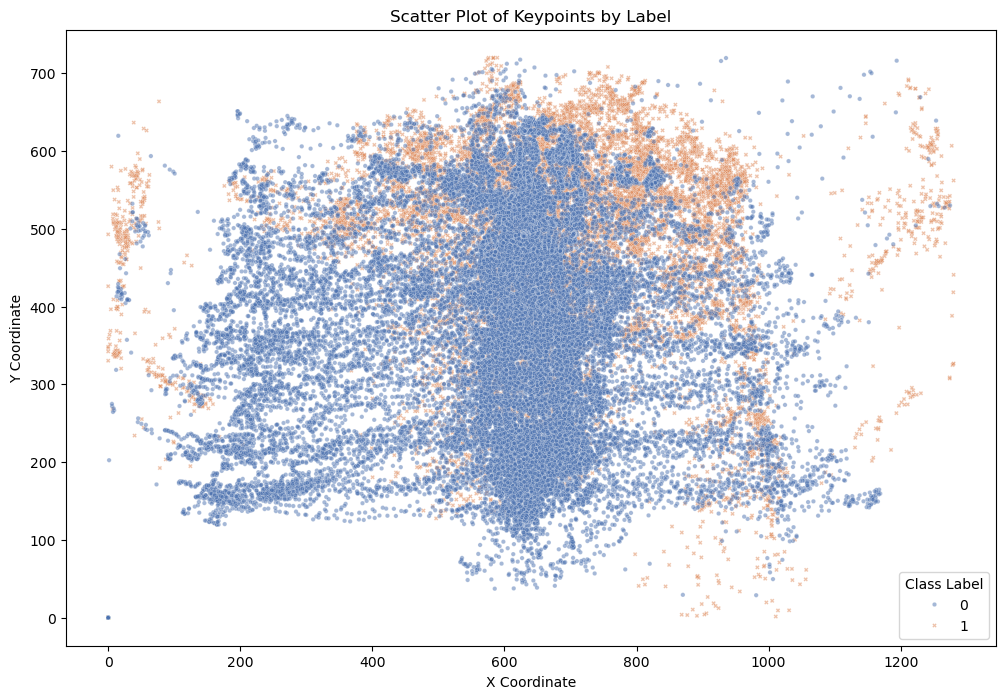

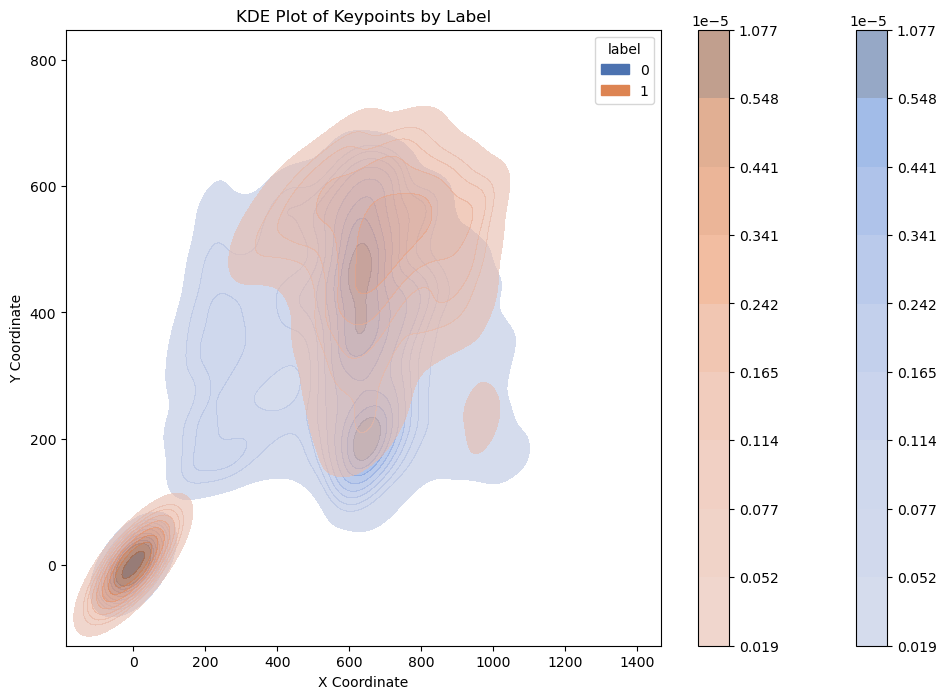

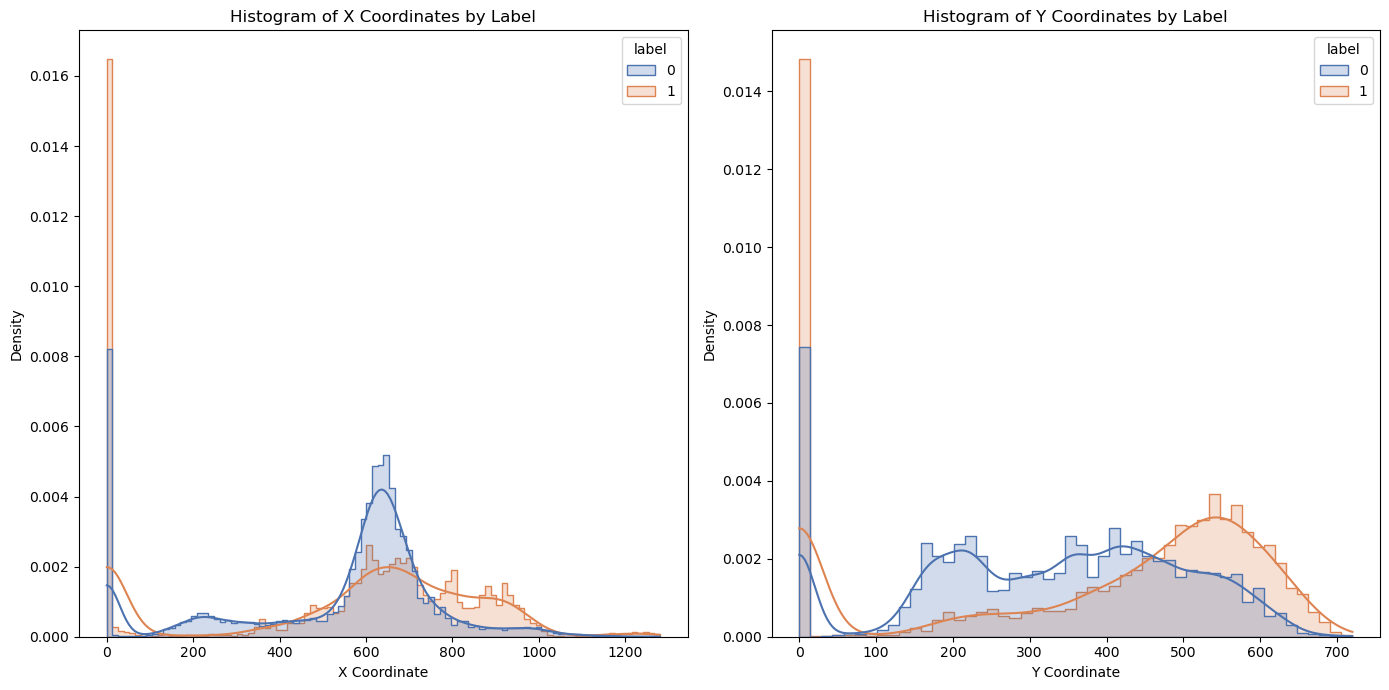

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the labeled CSV file
labeled_csv = "yolo_keypoints_labeled_interpolated.csv" # Replace with your labeled CSV path

# Load the CSV
df = pd.read_csv(labeled_csv)

# Inspect the DataFrame
print("Labeled Keypoints Data:")
print(df.head())

# Number of keypoints
num_keypoints = 17

# Separate the keypoints by label
labels = df['label'].unique()  # Get unique classes/labels

# Function to extract keypoints as a flattened DataFrame
def extract_flat_keypoints(df, num_keypoints):
    x_values = []
    y_values = []
    label_values = []
    for idx, row in df.iterrows():
        for i in range(1, num_keypoints + 1):
            x_values.append(row[f'keypoint_{i}_x'])
            y_values.append(row[f'keypoint_{i}_y'])
            label_values.append(row['label'])
    return pd.DataFrame({'x': x_values, 'y': y_values, 'label': label_values})

# Flatten keypoints for visualization
keypoints_flat = extract_flat_keypoints(df, num_keypoints)

# Plot Scatter Plots for Each Label
plt.figure(figsize=(12, 8))
sns.scatterplot(data=keypoints_flat, x='x', y='y', hue='label', style='label', palette='deep', alpha=0.5, s=10)
plt.title("Scatter Plot of Keypoints by Label")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title="Class Label")
plt.show()

# KDE Plot for Keypoint Distribution by Label
plt.figure(figsize=(12, 8))
sns.kdeplot(data=keypoints_flat, x='x', y='y', hue='label', fill=True, palette='deep', alpha=0.6, cbar=True)
plt.title("KDE Plot of Keypoints by Label")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

# Histograms for X and Y Coordinates Grouped by Label
plt.figure(figsize=(14, 7))

# X Coordinate Histogram
plt.subplot(1, 2, 1)
sns.histplot(data=keypoints_flat, x='x', hue='label', kde=True, palette='deep', element='step', stat='density', common_norm=False)
plt.title("Histogram of X Coordinates by Label")
plt.xlabel("X Coordinate")

# Y Coordinate Histogram
plt.subplot(1, 2, 2)
sns.histplot(data=keypoints_flat, x='y', hue='label', kde=True, palette='deep', element='step', stat='density', common_norm=False)
plt.title("Histogram of Y Coordinates by Label")
plt.xlabel("Y Coordinate")

plt.tight_layout()
plt.show()


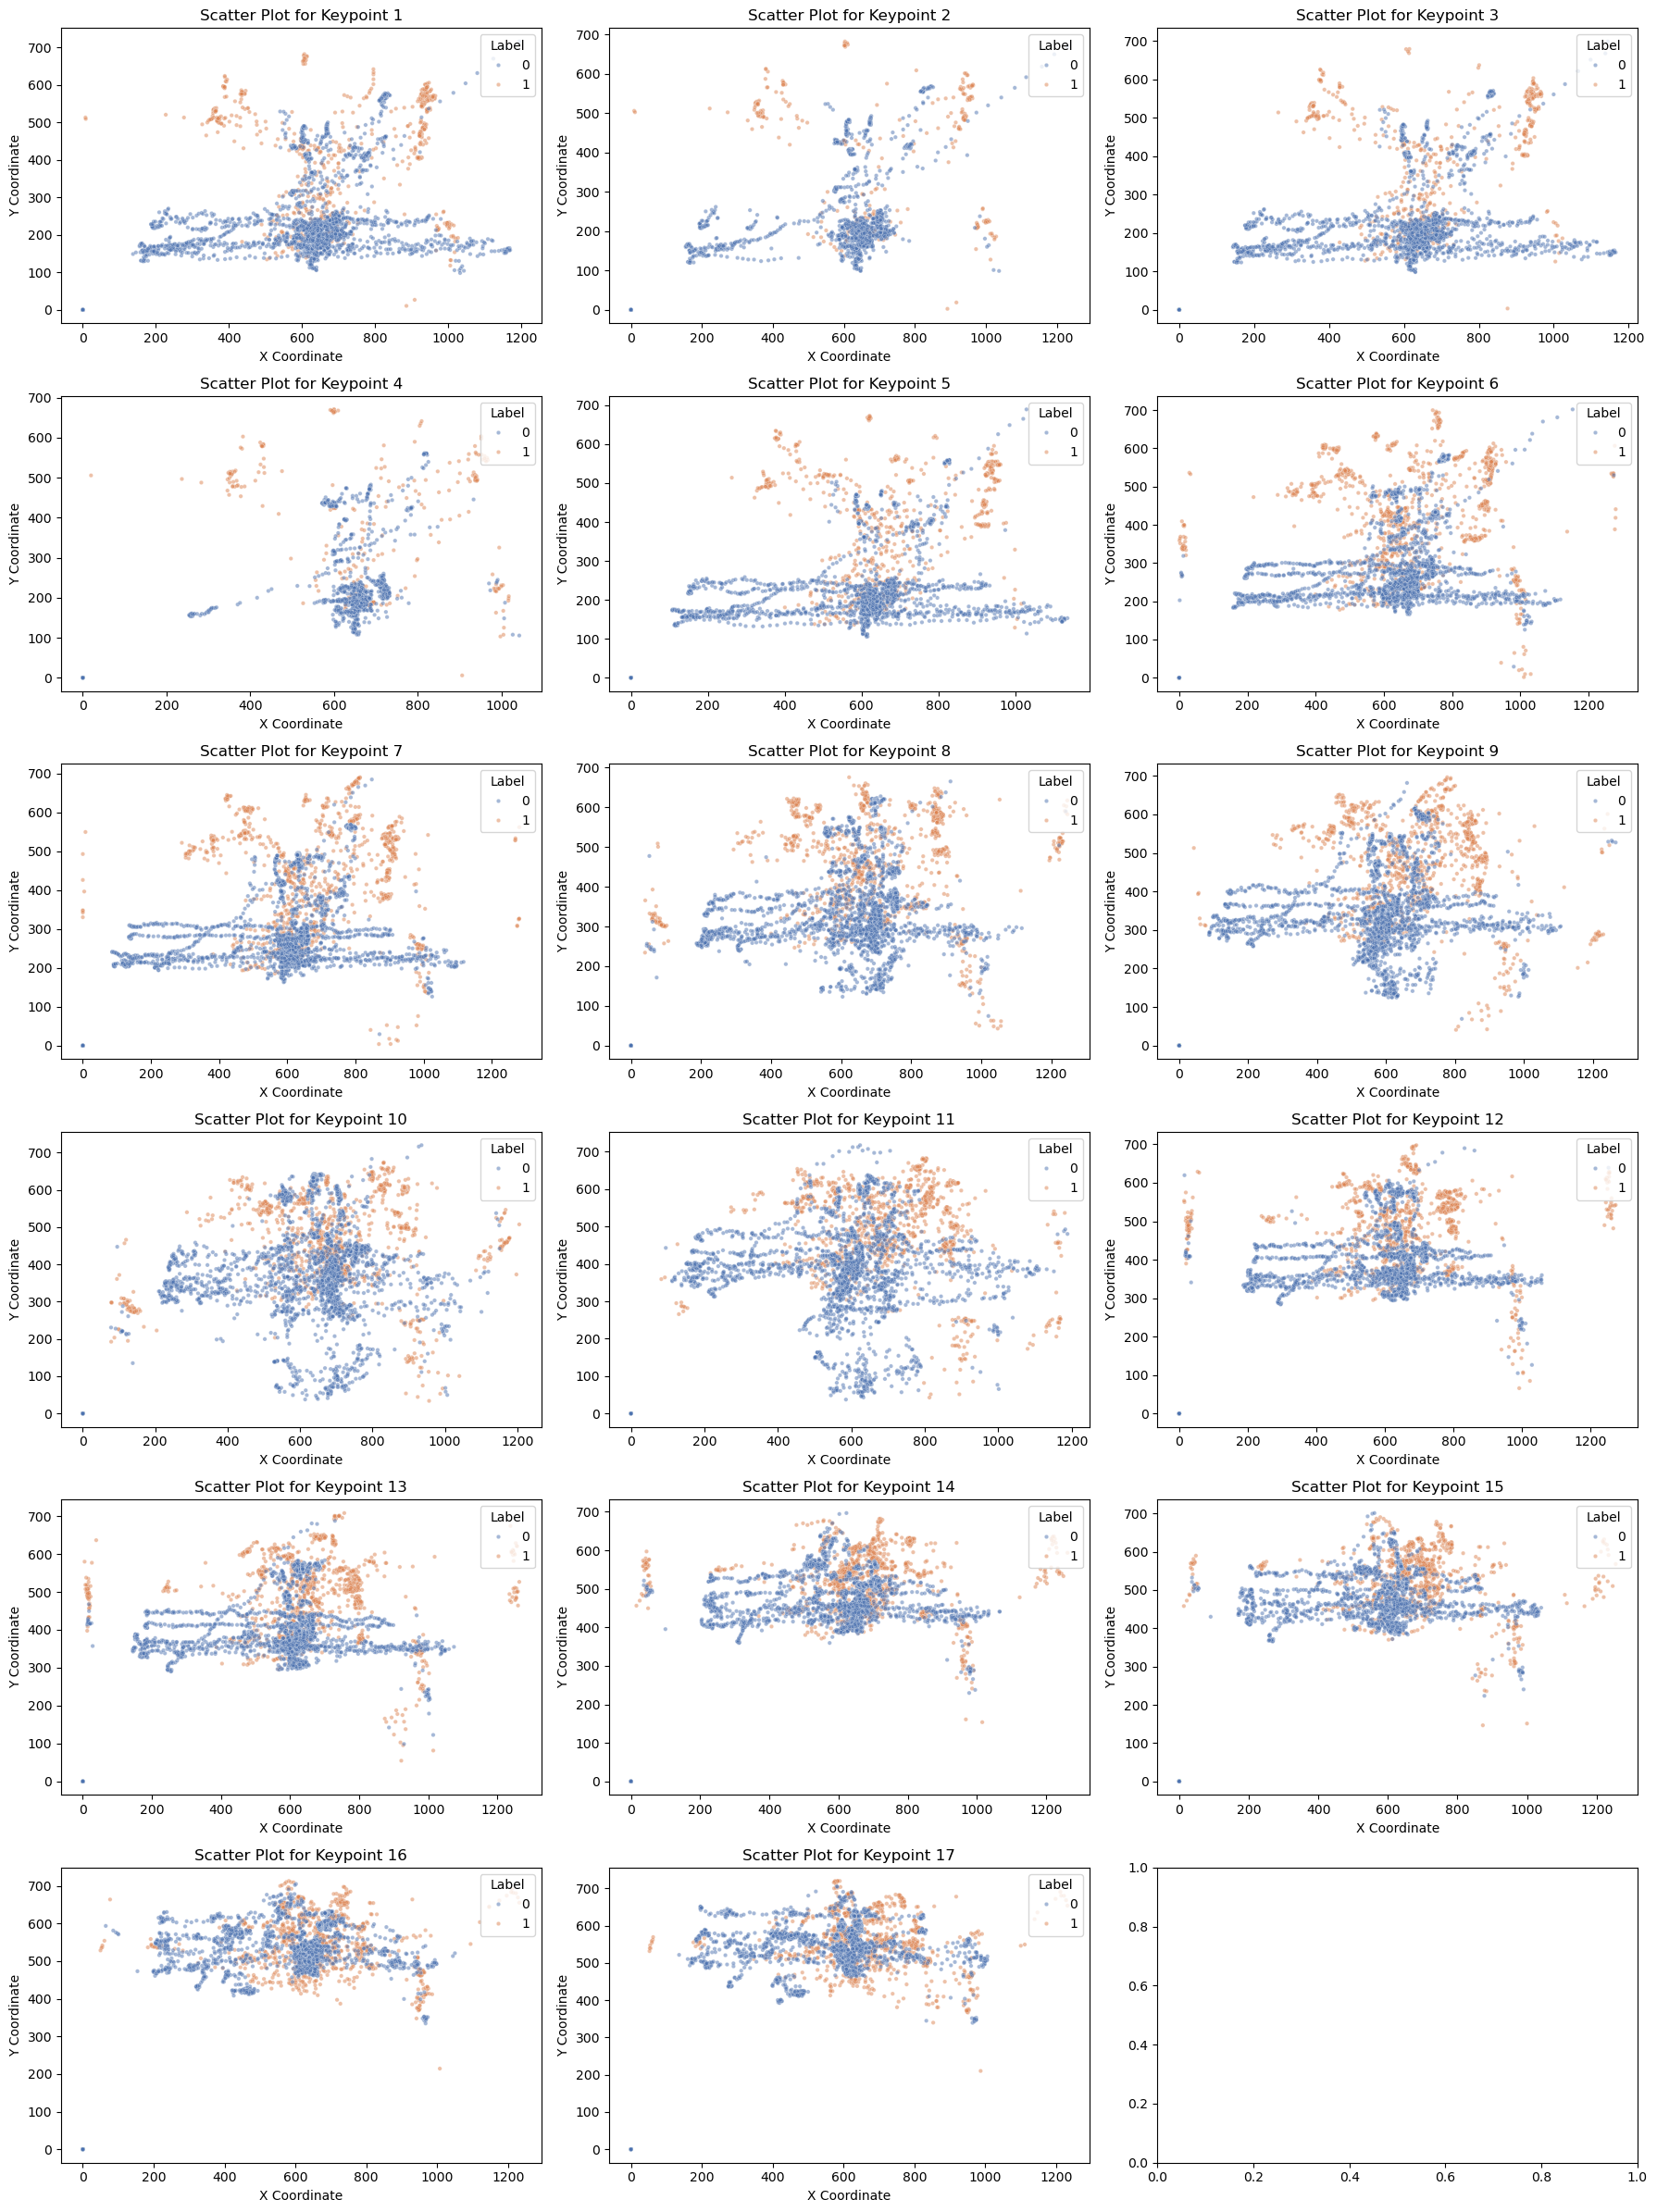

In [143]:
# Plot each keypoint separately
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 24))  # Adjust rows/columns for 17 keypoints
axes = axes.flatten()  # Flatten axes for easier indexing

for i in range(1, 18):  # Loop through 17 keypoints
    keypoint_data = keypoints_flat[(keypoints_flat.index % 17) == (i - 1)]  # Extract i-th keypoint
    
    # Scatter plot for the current keypoint
    sns.scatterplot(data=keypoint_data, x='x', y='y', hue='label', palette='deep', ax=axes[i-1], s=10, alpha=0.5)
    axes[i-1].set_title(f"Scatter Plot for Keypoint {i}")
    axes[i-1].set_xlabel("X Coordinate")
    axes[i-1].set_ylabel("Y Coordinate")
    axes[i-1].legend(title="Label", loc="upper right")

plt.tight_layout()
plt.show()


In [144]:
# import os
# import matplotlib.pyplot as plt
# from PIL import Image

# # Path to your YOLO output directory
# image_dir = "/kaggle/working/runs/pose/predict"

# # Get a list of image files in the directory
# image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# # Display images in a grid
# num_images = min(len(image_files), 80)  # Display up to 12 images
# num_cols = 4
# num_rows = (num_images + num_cols - 1) // num_cols

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# # Flatten axes for easier iteration
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     if i < num_images:
#         img_path = os.path.join(image_dir, image_files[i])
#         img = Image.open(img_path)
#         ax.imshow(img)
#         ax.set_title(os.path.basename(img_path))
#         ax.axis('off')
#     else:
#         # Hide unused axes
#         ax.axis('off')

# plt.tight_layout()
# plt.show()


In [145]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report
# import xgboost as xgb
# import joblib
# from sklearn.model_selection import GridSearchCV

# # Step 1: Load the labeled data
# data = pd.read_csv("yolo_keypoints_labeled_interpolated.csv")

# # Step 2: Split into features (X) and labels (y)
# # Drop 'image_name' since it's not a feature for training
# X = data.drop(columns=['image_name', 'label'])
# y = data['label']

# # Step 3: Train-test split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Step 4: Train the XGBoost Classifier
# # Step 4: Train the XGBoost Classifier
# model = xgb.XGBClassifier(
#     n_estimators=200,        # Best value from tuning
#     learning_rate=0.05,      # Best learning rate
#     max_depth=7,             # Best depth
#     min_child_weight=3,      # Helps control overfitting
#     gamma=0.1,               # Minimum loss reduction
#     subsample=0.9,           # Row sampling for trees
#     colsample_bytree=0.9,    # Feature sampling for trees
#     reg_alpha=0.1,           # L1 regularization
#     reg_lambda=0.2,          # L2 regularization
#     random_state=42          # Seed for reproducibility
# )


# # Train the model
# model.fit(X_train, y_train)

# # Step 5: Evaluate the Model
# # Make predictions
# y_pred = model.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")

# # Print a classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Step 6: Save the Model
# output_model = "xgboost_fall_detection_model.pkl"
# joblib.dump(model, output_model)
# print(f"Model saved to: {output_model}")


In [146]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_keypoints(file_path, scaler=None):
    """
    Load, impute, and normalize keypoints from the given file.
    
    Args:
        file_path (str): Path to the keypoints CSV file.
        scaler (StandardScaler): A pre-fit StandardScaler for inference, or None during training.
    
    Returns:
        np.ndarray: Preprocessed keypoints.
    """
    # Step 1: Load keypoints data
    keypoints = pd.read_csv(file_path)
    
    # Step 2: Impute missing values (replace NaN with column mean)
    keypoints_imputed = keypoints.fillna(keypoints.mean())

    # Step 3: Normalize keypoints using StandardScaler
    if scaler:
        keypoints_normalized = scaler.transform(keypoints_imputed)  # Use existing scaler (inference)
    else:
        scaler = StandardScaler()
        keypoints_normalized = scaler.fit_transform(keypoints_imputed)  # Fit and transform (training)

    return keypoints_normalized, scaler


def load_data_with_preprocessing(root_dir):
    """
    Load and preprocess data, scaling and imputing missing values.
    
    Args:
        root_dir (str): Root directory containing subject folders.
    
    Returns:
        tuple: Preprocessed keypoints data, corresponding labels, and the scaler object.
    """
    data = []
    labels = []
    scaler = StandardScaler()  # Initialize a single scaler for all files

    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if os.path.isdir(subject_path):
            for activity_type in os.listdir(subject_path):
                activity_path = os.path.join(subject_path, activity_type)
                if os.path.isdir(activity_path):
                    label = 1 if activity_type == 'fall' else 0
                    for activity_class in os.listdir(activity_path):
                        class_path = os.path.join(activity_path, activity_class)
                        if os.path.isdir(class_path):
                            for file in os.listdir(class_path):
                                file_path = os.path.join(class_path, file)
                                if os.path.isfile(file_path):
                                    # Preprocess keypoints
                                    keypoints, scaler = preprocess_keypoints(file_path, scaler)
                                    data.append(keypoints)
                                    labels.append(label)

    return np.array(data), np.array(labels), scaler


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\tohru\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\tohru\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\tohru\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\tohru\anaconda3\Lib\site-packages\

Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       519
           1       0.99      0.98      0.99       256

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775



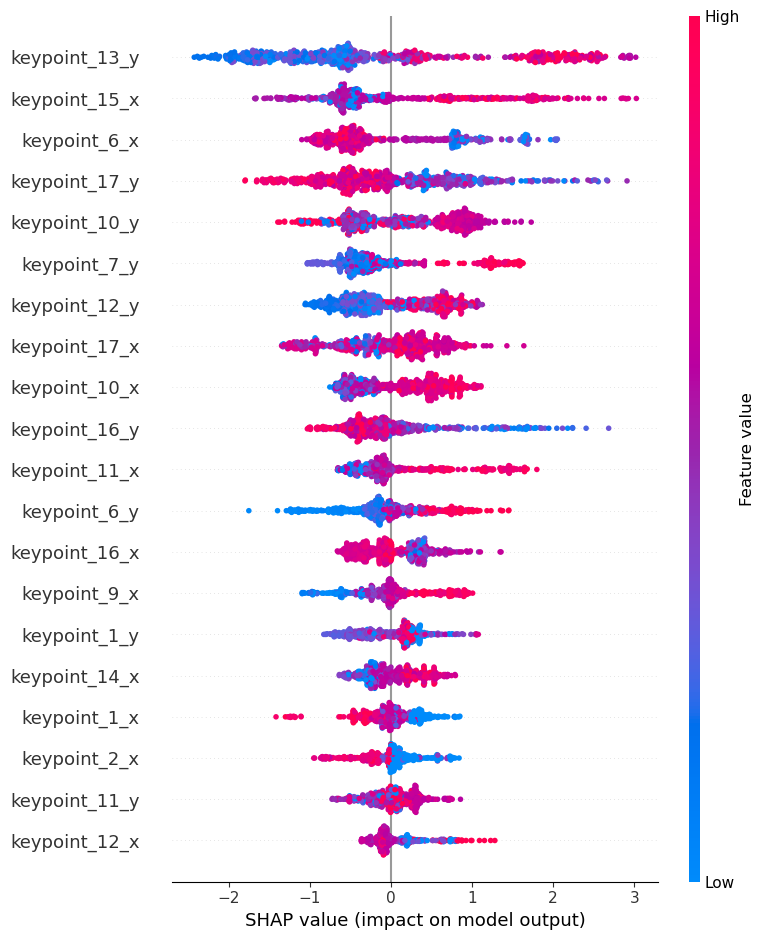

Model saved to: best_xgboost_model.pkl


In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import joblib
from sklearn.model_selection import GridSearchCV

# Step 1: Load the labeled data
data = pd.read_csv("yolo_keypoints_labeled_interpolated.csv")

# Step 2: Split into features (X) and labels (y)
# Drop 'image_name' since it's not a feature for training
X = data.drop(columns=['image_name', 'label'])
y = data['label']

# Step 3: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# joblib.dump(scaler, "scaler.pkl")


from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# print(f"After SMOTE: {y_train_res.value_counts()}")


param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 7],
    # 'min_child_weight': [1, 5],
    'gamma': [0, 0.1, 0.2],
    # 'subsample': [0.8, 1],
    # 'colsample_bytree': [0.8, 0.9, 1]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Step 5: Evaluate the Model
# Make predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

import shap

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


# Step 6: Save the Model
output_model = "best_xgboost_model.pkl"
joblib.dump(best_model, output_model)
print(f"Model saved to: {output_model}")


In [148]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil
from ultralytics import YOLO

def load_test_images_in_batches(test_dir, target_size=(640, 640), batch_size=32):
    """
    Loads and preprocesses images from the test folder in batches.
    """
    image_files = [f for f in os.listdir(test_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i + batch_size]
        batch_images = []
        batch_ids = []

        for file in batch_files:
            img_path = os.path.join(test_dir, file)
            try:
                # Load and preprocess the image
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
                batch_images.append(img_array)
                batch_ids.append(file)
            except Exception as e:
                print(f"Error processing {file}: {e}")

        yield np.array(batch_images), batch_ids

# Step 1: Test Directory
test_dir = 'test'

# # Step 2: Validate File Paths
# if not os.path.exists(test_dir) or len(os.listdir(test_dir)) == 0:
#     raise FileNotFoundError(f"No images found in directory: {test_dir}")

# # Step 3: Create YOLO Input Directory
# yolo_input_dir = "yolo_input_test"  # Use a separate folder
# clear_output_directory(yolo_input_dir)
# os.makedirs(yolo_input_dir, exist_ok=True)

# # Copy images into YOLO input directory
# image_files = [f for f in os.listdir(test_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
# for img_file in image_files:
#     img_path = os.path.join(test_dir, img_file)
#     if os.path.exists(img_path):
#         unique_filepath = os.path.join(yolo_input_dir, img_file)
#         shutil.copy(img_path, unique_filepath)  # Copy to a separate folder
#     else:
#         print(f"File not found or inaccessible: {img_path}")

# # Verify the total number of files copied
# copied_files = os.listdir(yolo_input_dir)
# print(f"Total files copied to YOLO input directory: {len(copied_files)}")

# Step 4: Initialize YOLOv8 Pose Model
model = YOLO('yolov8n-pose.pt')

# Step 5: Run YOLO Predictions
results = model.predict(
    source=test_dir,  # Directory containing images
    task="pose",
    imgsz=640,
    verbose=False,
    save=False # Save predictions
)

# Output the saved results directory
print(f"Predictions saved in: {results[0].save_dir}")




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Predictions saved in: None


In [149]:
import csv
import os

# Save keypoints to CSV
output_csv = "yolo_predictions.csv"
with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write header: image_name + flattened keypoints (x, y for 17 keypoints)
    header = ['image_name'] + [f'keypoint_{i}_x' for i in range(1, 18)] + [f'keypoint_{i}_y' for i in range(1, 18)]
    writer.writerow(header)

    # Iterate through results
    for result in results:
        if hasattr(result, 'keypoints') and result.keypoints is not None:
            keypoints_tensor = result.keypoints.xy.cpu().numpy()  # Extract keypoints (x, y)
            image_name = os.path.basename(result.path)  # Get the image filename

            for detection_keypoints in keypoints_tensor:  # Iterate over detections
                flattened_keypoints = detection_keypoints.flatten()  # Flatten (x, y) coordinates for 17 keypoints
                writer.writerow([image_name] + list(flattened_keypoints))  # Write to CSV

print(f"Keypoints saved to: {output_csv}")


Keypoints saved to: yolo_predictions.csv


In [150]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Load the test set keypoints CSV
test_csv = "yolo_predictions.csv"
test_keypoints = pd.read_csv(test_csv)

# Extract image names and keypoints
image_names = test_keypoints['image_name']
keypoints = test_keypoints.drop('image_name', axis=1).values

# Load the pre-trained XGBoost model (saved using joblib)
from joblib import load
xgb_model = load(output_model)

# Make predictions
predictions = xgb_model.predict(keypoints)

# Convert probabilities to binary labels (assuming binary classification)
labels = (predictions > 0.5).astype(int)

# Save predictions with image names to a new CSV
output_csv = "test_predictions.csv"
output_df = pd.DataFrame({'id': image_names, 'label': labels})
output_df.to_csv(output_csv, index=False)

print(f"Predictions saved to: {output_csv}")


Predictions saved to: test_predictions.csv


In [151]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from joblib import load
import xgboost as xgb

# Load the test set keypoints CSV
test_csv = "yolo_predictions.csv"
test_keypoints = pd.read_csv(test_csv)

# Extract image names and keypoints
image_names = test_keypoints['image_name']
keypoints = test_keypoints.drop('image_name', axis=1).values

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
keypoints_imputed = imputer.fit_transform(keypoints)

# Load the pre-trained XGBoost model (saved using joblib)
output_model = "best_xgboost_model.pkl"  # Ensure this path is correct
xgb_model = load(output_model)

# Make predictions
predictions_proba = xgb_model.predict_proba(keypoints_imputed)

# Extract the confidence values for the positive class (assuming binary classification)
confidence_values = predictions_proba[:, 1]

# Convert probabilities to binary labels (assuming binary classification)
labels = (confidence_values > 0.5).astype(int)

# Adjust confidence values based on the predicted label
adjusted_confidence_values = np.where(labels == 0, 1 - confidence_values, confidence_values)

# Save predictions with image names and adjusted confidence values to a new CSV
output_csv_with_probs = "test_predictions_with_probs.csv"
output_df_with_probs = pd.DataFrame({'id': image_names, 'label': labels, 'confidence': adjusted_confidence_values})
output_df_with_probs.to_csv(output_csv_with_probs, index=False)

output_csv = "test_predictions.csv"
output_df = pd.DataFrame({'id': image_names, 'label': labels})
output_df.to_csv(output_csv, index=False)

print(f"Predictions saved to: {output_csv_with_probs} and {output_csv}")

Predictions saved to: test_predictions_with_probs.csv and test_predictions.csv


In [152]:
def visualize_incorrect_predictions(incorrect_predictions, image_dir, grid_size=5, resize_to=(100, 100)):
    """
    Displays the images for the incorrect predictions in a compact grid layout with resized images.
    """
    num_images = min(len(incorrect_predictions), grid_size * (grid_size *14))  # Max images to show
    rows = math.ceil(num_images / grid_size)
    cols = grid_size

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Smaller figure size
    axes = axes.flatten()  # Flatten for easy iteration

    for idx, (photo_id, predicted_label, true_label) in enumerate(incorrect_predictions[:num_images]):
        image_path = Path(image_dir) / photo_id  # Construct the full image path
        
        # Check if the image exists
        if not image_path.exists():
            print(f"Image not found: {image_path}")
            axes[idx].axis("off")
            continue
        
        try:
            # Load and resize the image
            img = Image.open(image_path)
            img = img.resize(resize_to, Image.Resampling.LANCZOS)  # Resize to reduce load time
            
            # Display the image
            axes[idx].imshow(img)
            axes[idx].axis("off")
            axes[idx].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=8)
        except Exception as e:
            print(f"Error loading image {photo_id}: {e}")
            axes[idx].axis("off")
    
    # Hide any unused axes
    for idx in range(num_images, len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout(pad=1.0)
    plt.show()

In [153]:
import csv
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
# Function to load CSV data
def load_csv(file_path):
    """Loads a CSV file and returns a dictionary with photo ID as key and label as value."""
    data_dict = {}
    with open(file_path, mode='r') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader)  # Skip the header
        
        for row in csv_reader:
            # Check if the row contains a valid format
            if len(row) != 2:
                print(f"Skipping invalid row: {row}")
                continue
            
            full_path_or_id, label = row
            # Extract photo ID from the full path if necessary
            photo_id = Path(full_path_or_id).name  # This ensures we only get the filename
            data_dict[photo_id] = int(label)  # Convert label to integer
    
    return data_dict

In [154]:
def calculate_accuracy_and_log_incorrect(predicted_csv, ground_truth_csv):
    """
    Compares the predicted labels to the ground truth labels and calculates accuracy.
    Also logs incorrect predictions.
    """
    # Load CSVs into dictionaries
    predicted = load_csv(predicted_csv)
    ground_truth = load_csv(ground_truth_csv)
    
    # Initialize counters and lists for incorrect predictions
    correct = 0
    total = 0
    incorrect_predictions = []
    
    y_true = []  # True labels
    y_pred = []  # Predicted labels
    
    for photo_id, true_label in ground_truth.items():
        # Check if the photo ID exists in the predicted data
        if photo_id in predicted:
            total += 1  # Increment total for every matched ID
            predicted_label = predicted[photo_id]
            y_true.append(true_label)
            y_pred.append(predicted_label)
            
            if predicted_label == true_label:
                correct += 1  # Increment correct if labels match
            else:
                # Log the incorrect prediction
                incorrect_predictions.append((photo_id, predicted_label, true_label))
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total, incorrect_predictions, y_true, y_pred

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    """
    Generate and plot a confusion matrix with a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()





In [ ]:
import math
predicted_csv = 'test_predictions.csv'  # Replace with your predicted CSV path
ground_truth_csv = 'ground_truth.csv'  # Replace with your ground truth CSV path
image_directory = 'test'  # Replace with the directory containing the images

# Get accuracy and incorrect predictions
accuracy, correct, total, incorrect_predictions, y_true, y_pred = calculate_accuracy_and_log_incorrect(predicted_csv, ground_truth_csv)
# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}% ({correct}/{total} correct predictions)")


# Visualize incorrect predictions
if incorrect_predictions:
    print(f"Visualizing {len(incorrect_predictions)} incorrect predictions...")
    visualize_incorrect_predictions(incorrect_predictions, image_directory)
else:
    print("No incorrect predictions to visualize.")

Accuracy: 86.57% (1863/2152 correct predictions)
Visualizing 289 incorrect predictions...


Accuracy: 90.20% (1941/2152 correct predictions)


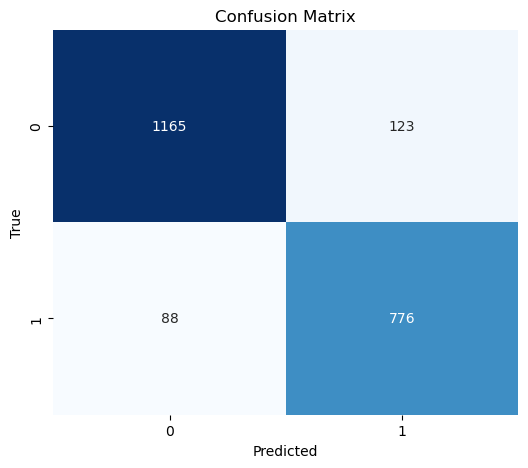

In [124]:
# Example usage
predicted_csv = output_csv  # Replace with your predicted CSV path
ground_truth_csv = 'ground_truth.csv'  # Replace with your ground truth CSV path

# Get accuracy and incorrect predictions
accuracy, correct, total, incorrect_predictions, y_true, y_pred = calculate_accuracy_and_log_incorrect(predicted_csv, ground_truth_csv)

# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}% ({correct}/{total} correct predictions)")

# Plot the confusion matrix
labels = [0, 1]  # Change if you have more classes
plot_confusion_matrix(y_true, y_pred, labels)


In [125]:
# # Example usage
# predicted_csv = '/kaggle/working/test_predictions.csv'  # Replace with your predicted CSV path
# ground_truth_csv = '/kaggle/input/label-diri/file_labels (3).csv'  # Replace with your ground truth CSV path

# # Get accuracy and incorrect predictions
# accuracy, correct, total, incorrect_predictions, y_true, y_pred = calculate_accuracy_and_log_incorrect(predicted_csv, ground_truth_csv)

# # Print accuracy
# print(f"Accuracy: {accuracy * 100:.2f}% ({correct}/{total} correct predictions)")

# # Plot the confusion matrix
# labels = [0, 1]  # Change if you have more classes
# plot_confusion_matrix(y_true, y_pred, labels)
